## Analyse von Phyphox Daten

In [195]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series
import numpy as np
from scipy import signal 
import os
%matplotlib ipympl

In [196]:
working_dir = "/Users/dirkm/Documents/Github/python_experiments"

In [197]:
os.chdir(working_dir)
new_dir = os.getcwd()
print("New current working directory:", new_dir)

New current working directory: C:\Users\dirkm\Documents\Github\python_experiments


In [198]:
#experiment_dir = "2024-07-14_12-54-33"
#experiment_dir = "2024-07-14_13-11-02"
#experiment_dir = "2024-07-14_13-02-27"
#experiment_dir = "2024-07-14_13-44-06"
#experiment_dir = "2024-07-14_12-56-08"
#experiment_dir = "2024-07-14_13-21-20"

###

experiment_dir = "2024-07-20_12-12-52"

In [199]:
#data_dir = working_dir + "/Beschleunigung ohne g " + experiment_dir
data_dir = working_dir + "/My Experiment " + experiment_dir

In [200]:
os.chdir(data_dir)
new_dir = os.getcwd()
print("New current working directory:", new_dir)

New current working directory: C:\Users\dirkm\Documents\Github\python_experiments\My Experiment 2024-07-20_12-12-52


In [201]:
#testdata = pd.read_csv("Raw data.csv") 
testdata = pd.read_csv("Linear Acceleration.csv") 
testdata.head()

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2)
0,0.385846,-0.080311,-0.004656,0.084474
1,0.390821,-0.091195,-0.006871,0.133761
2,0.395826,-0.053565,0.004718,0.085118
3,0.400800,-0.090871,-0.023101,0.061312
4,0.405774,-0.023580,0.002915,0.054543


In [202]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11930 entries, 0 to 11929
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Time (s)                       11930 non-null  float64
 1   Linear Acceleration x (m/s^2)  11930 non-null  float64
 2   Linear Acceleration y (m/s^2)  11930 non-null  float64
 3   Linear Acceleration z (m/s^2)  11930 non-null  float64
dtypes: float64(4)
memory usage: 372.9 KB


In [203]:
df = testdata.rename(columns={"Time (s)": "t", "Linear Acceleration x (m/s^2)" : "x", "Linear Acceleration y (m/s^2)" : "y", "Linear Acceleration z (m/s^2)" : "z" })

In [204]:
df.head()

,t,x,y,z
0,0.385846,-0.080311,-0.004656,0.084474
1,0.390821,-0.091195,-0.006871,0.133761
2,0.395826,-0.053565,0.004718,0.085118
3,0.400800,-0.090871,-0.023101,0.061312
4,0.405774,-0.023580,0.002915,0.054543


<Axes: title={'center': 'Zeitreihe Beschleunigung'}, xlabel='t [s]', ylabel='a [m/s^2]'>

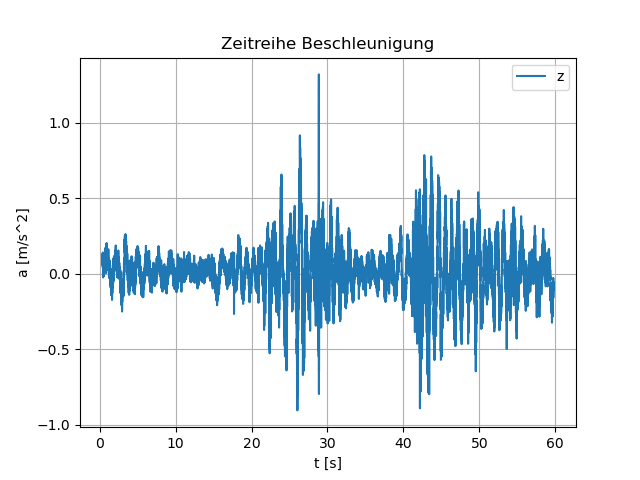

In [205]:
df.plot("t","z", grid=True, xlabel = "t [s]", ylabel = "a [m/s^2]", title="Zeitreihe Beschleunigung")

In [206]:
# Abtastintervall
dt = df.t[1] - df.t[0]
fs = 1/dt
print(fs)

201.03068431850173


In [207]:
f, PXX = signal.periodogram(df.x, fs)
f, PYY = signal.periodogram(df.y, fs)
f, PZZ = signal.periodogram(df.z, fs)

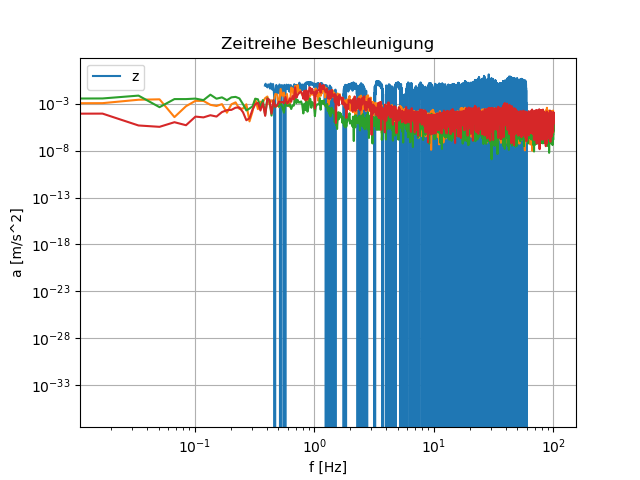

In [208]:
plt.loglog(f, PXX)
plt.loglog(f, PYY)
plt.loglog(f, PZZ)
plt.xlabel("f [Hz]")
plt.show()

In [209]:
#Ersetze den Doppel-Integrator durch Kalman Filter + Bias Remover + Integrator + Bias Remover
# f = KalmanFilter(dim_x=3, dim_z=1)

X = np.array([[0.0], [0.0], [0.0]]) # [x, v, a] 
A = np.array([[1.0, dt, 0.0],[0.0, 1.0, dt],[0.0, 0.0, 1.0]])
H = np.array([[0.0, 0.0, 1.0]]) # Messung der Beschleunigunng
R = np.array([[1.0]])*10
P = np.eye(3,3)
Q = np.eye(3,3)*0.1
U = 0
B = np.zeros([3,1])

In [210]:
# Funktionen für die Kalman Filterung 

In [211]:
def kf_predict(X, P, A, Q, B, U):
    X = np.dot(A, X) + np.dot(B, U)
    P = np.dot(A, np.dot(P, A.T)) + Q
    return(X,P)

In [212]:
def kf_update(X, P, Y, H, R):
    IM = np.dot(H, X)
    IS = R + np.dot(H, np.dot(P, H.T))
    K = np.dot(P, np.dot(H.T, np.linalg.inv(IS)))
    X = X + np.dot(K, (Y-IM))
    P = P - np.dot(K, np.dot(IS, K.T))
    LH = gauss_pdf(Y, IM, IS)
    return (X,P,K,IM,IS,LH)

In [213]:
def gauss_pdf(X, M, S):
    
    if np.shape(M)[1] == 1:
        DX = X - np.tile(M, np.shape(X)[1])
        E = 0.5 * np.sum(DX * (np.dot(np.linalg.inv(S), DX)), axis=0)
        E = E + 0.5 * np.shape(M)[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    elif np.shape(X)[1] == 1:
        DX = np.tile(X, M.shape()[1])- M
        E = 0.5 * np.sum(DX * (np.dot(np.linalg.inv(S), DX)), axis=0)
        E = E + 0.5 * np.shape(M)[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    else:
        DX = X-M
        E = 0.5 * np.dot(DX.T, np.dot(np.linalg.inv(S), DX))
        E = E + 0.5 * np.shape(M)[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    return (P[0],E[0])

In [214]:
a_biased = df.z
t = df.t

In [215]:
# Bias removal with 1 tap LMS filter

#n = 0
#a = np.zeros_like(a_biased)
#w = np.zeros_like(a_biased)
#mu = 0.01
#while n < len(a)-1:
#    w[n+1] = w[n]*(1-2*mu) + 2*mu*a_biased[n] 
#    a[n] = a_biased[n] - w[n+1]
#    n += 1 

In [218]:
a = a_biased

In [219]:
#plt.figure()
#plt.subplot(2,1,1)
#plt.plot(t, a_biased, 'r', label = "raw data")
#plt.plot(t, a, 'b:', label = "filtered")

#plt.ylabel("a [m/s^2]")
#plt.grid()
#plt.legend()
#plt.subplot(2,1,2)
#plt.plot(t, w)
#plt.xlabel("t [s]")
#plt.ylabel("bias")
#plt.grid()


In [220]:
f, Paa = signal.periodogram(a, fs)
f, Pab = signal.periodogram(a_biased, fs)

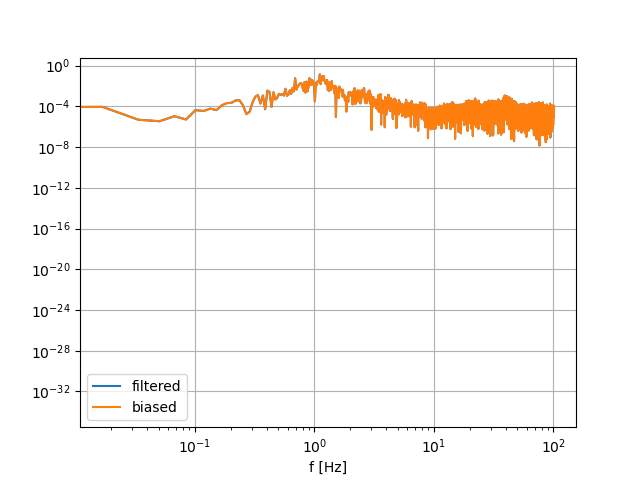

In [221]:
plt.figure()
plt.loglog(f, Paa, label = "filtered")
plt.loglog(f, Pab, label = "biased")
plt.xlabel("f [Hz]")
plt.grid()
plt.legend()
plt.show()

In [222]:
n = 0
d_v = np.zeros_like(a)
d_a = np.zeros_like(a)

In [223]:
while n < len(a):
    (X, P) = kf_predict(X, P, A, Q, B, U)
    Y = np.array([[a[n]]])
    (X, P, K, IM, IS, LH) = kf_update(X, P, Y, H, R)
    d_v[n] = np.ndarray.item(X, 1)
    d_a[n] = np.ndarray.item(X, 2)
    n += 1 

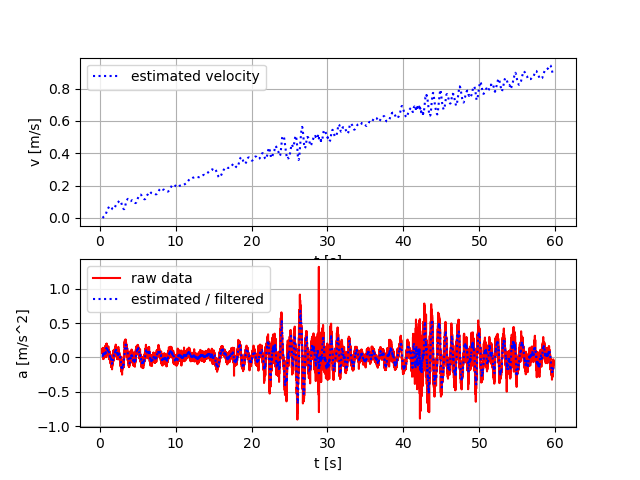

In [224]:
plt.figure()

plt.subplot(2,1,1)
plt.plot(t, d_v, 'b:', label = "estimated velocity")
plt.xlabel("t [s]")
plt.ylabel("v [m/s]")
plt.grid()
plt.legend()

plt.subplot(2,1,2)
plt.plot(t, a, 'r', label = "raw data")
plt.plot(t, d_a, 'b:', label = "estimated / filtered")
plt.xlabel("t [s]")
plt.ylabel("a [m/s^2]")
plt.grid()
plt.legend()

plt.show()

In [239]:
# Bias removal with 1 tap LMS filter

n = 0
e = np.zeros_like(d_v)
w = np.zeros_like(d_v)
mu = 0.001
while n < len(d_v)-1:
    w[n+1] = w[n]*(1-2*mu) + 2*mu*d_v[n] 
    e[n] = d_v[n] - w[n+1]
    n += 1 

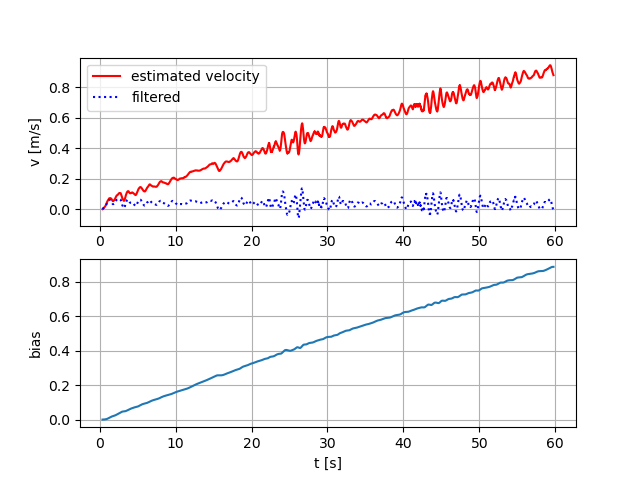

In [240]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(t, d_v, 'r', label = "estimated velocity")
plt.plot(t, e, 'b:', label = "filtered")

plt.ylabel("v [m/s]")
plt.grid()
plt.legend()
plt.subplot(2,1,2)
plt.plot(t, w)
plt.xlabel("t [s]")
plt.ylabel("bias")
plt.grid()


In [241]:
# Integrator einfach
A = 1
B = dt
C = 1
D = 0

sys = signal.StateSpace(A, B, C, D, dt=dt)

In [242]:
t = t.to_numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [243]:
td2, d_2, x = signal.dlsim(sys, e, t, 0)

In [244]:
n = 0
e2 = np.zeros_like(d_2)
w = 0
mu = 0.01
while n < len(d_2)-1:
    w = w*(1-2*mu) + 2*mu*d_2[n] 
    e2[n] = d_2[n] - w
    n += 1 

C:\Users\dirkm\AppData\Local\Temp\ipykernel_19700\800944071.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


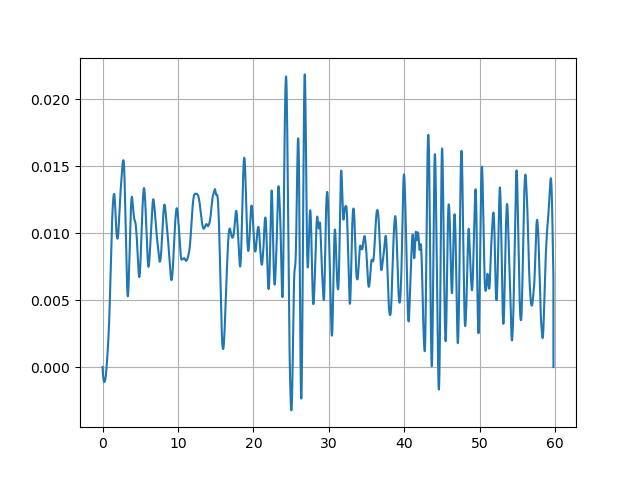

In [245]:
plt.figure()
plt.plot(td2, e2)
#plt.plot(td2,d_2)
plt.grid()

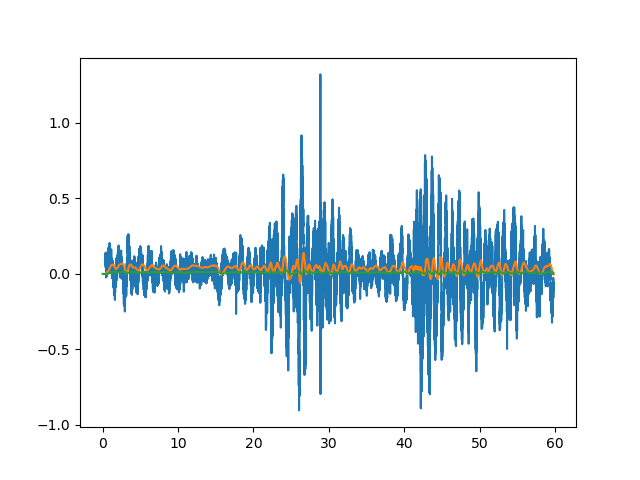

In [246]:
plt.figure()
plt.plot(t,a)
plt.plot(t,e)
plt.plot(td2, e2)